In [1]:
# Cell 0: Install dependencies
!pip install transformers datasets evaluate seqeval accelerate wandb
!pip install pandas numpy matplotlib seaborn
!pip install sentencepiece sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=18d1e09c5e1d341c693537be5bba1bd7be7401f679f9460f16be23165cddd120
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 25.0 MB/s eta 0:00:0000:01


In [2]:
# Cell 1: Setup and imports

import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from evaluate import load
import wandb
import os
from sklearn.metrics import classification_report
import json

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


2026-01-07 13:59:57.253644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767794397.409743      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767794397.453754      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767794397.813220      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767794397.813253      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767794397.813256      55 computation_placer.cc:177] computation placer alr

In [3]:
# Cell 2: Configuration
class TeacherConfig:
    MODEL_NAME = "xlm-roberta-large"
    DATASET_NAME = "wikiann"
    LANGUAGES = ["en", "de", "fr"]  # Start with 3 languages
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    GRADIENT_ACCUMULATION_STEPS = 2
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    LABEL_NAMES = [
        "O",
        "B-PER", "I-PER",
        "B-ORG", "I-ORG",
        "B-LOC", "I-LOC"
    ]
    NUM_LABELS = 7
    OUTPUT_DIR = "./models/teacher"
    LOGGING_DIR = "./logs/teacher"

config = TeacherConfig()

In [4]:
# Cell 3: Initialize W&B for experiment tracking
wandb.init(
    project="multilingual-ner",
    name="teacher-model-training",
    mode="offline",  # <--- Add this line to go Offline
    config={
        "model": config.MODEL_NAME,
        "languages": config.LANGUAGES,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE,
        "epochs": config.NUM_EPOCHS
    }
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [5]:
# Cell 4: Load and prepare multilingual dataset

def load_multilingual_dataset(languages, max_train_samples=20000):
    datasets_dict = {}
    
    # 1. Load individual datasets from Hugging Face
    for lang in languages:
        try:
            print(f"Loading {lang} dataset...")
            datasets_dict[lang] = load_dataset(config.DATASET_NAME, lang)
        except Exception as e:
            print(f"Error loading {lang}: {e}")
    
    train_list, val_list, test_list = [], [], []
    
    # 2. Calculate how many samples to take per language to be fair
    # This ensures an even distribution across your chosen languages
    samples_per_lang = max_train_samples // len(languages)
    eval_samples_per_lang = samples_per_lang // 4  # Keep validation smaller for speed

    for lang, ds in datasets_dict.items():
        # Shuffle and select a subset for each language to keep it representative
        train_sub = ds['train'].shuffle(seed=42).select(range(min(samples_per_lang, len(ds['train']))))
        val_sub = ds['validation'].shuffle(seed=42).select(range(min(eval_samples_per_lang, len(ds['validation']))))
        
        # Select a small portion of the test set for the specific language
        test_sub = ds['test'].shuffle(seed=42).select(range(min(500, len(ds['test']))))
        
        # Add 'language' column to ALL splits to avoid ValueError during tokenization (.map)
        train_list.append(train_sub.add_column("language", [lang] * len(train_sub)))
        val_list.append(val_sub.add_column("language", [lang] * len(val_sub)))
        test_list.append(test_sub.add_column("language", [lang] * len(test_sub)))
        
    # 3. Combine everything into a single DatasetDict
    # Using concatenate_datasets keeps the object as a Hugging Face Dataset (not a list)
    combined_dataset = DatasetDict({
        'train': concatenate_datasets(train_list).shuffle(seed=42),
        'validation': concatenate_datasets(val_list).shuffle(seed=42),
        'test': concatenate_datasets(test_list).shuffle(seed=42)
    })
    
    # Print statistics for verification
    print(f"\nCombined dataset sizes:")
    print(f"  Train: {len(combined_dataset['train'])}")
    print(f"  Validation: {len(combined_dataset['validation'])}")
    print(f"  Test: {len(combined_dataset['test'])}")
    
    return combined_dataset

# Run the loader
dataset = load_multilingual_dataset(config.LANGUAGES)

Loading en dataset...


README.md: 0.00B [00:00, ?B/s]

en/validation-00000-of-00001.parquet:   0%|          | 0.00/748k [00:00<?, ?B/s]

en/test-00000-of-00001.parquet:   0%|          | 0.00/748k [00:00<?, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Loading de dataset...


de/validation-00000-of-00001.parquet:   0%|          | 0.00/835k [00:00<?, ?B/s]

de/test-00000-of-00001.parquet:   0%|          | 0.00/832k [00:00<?, ?B/s]

de/train-00000-of-00001.parquet:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Loading fr dataset...


fr/validation-00000-of-00001.parquet:   0%|          | 0.00/673k [00:00<?, ?B/s]

fr/test-00000-of-00001.parquet:   0%|          | 0.00/678k [00:00<?, ?B/s]

fr/train-00000-of-00001.parquet:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/6666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/1666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/6666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/1666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/6666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/1666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]


Combined dataset sizes:
  Train: 19998
  Validation: 4998
  Test: 1500


In [6]:
# Cell 5: Initialize tokenizer and model
print(f"Loading tokenizer: {config.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

print(f"Loading model: {config.MODEL_NAME}")
model = AutoModelForTokenClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_LABELS,
    id2label={i: label for i, label in enumerate(config.LABEL_NAMES)},
    label2id={label: i for i, label in enumerate(config.LABEL_NAMES)},
    ignore_mismatched_sizes=True
)

Loading tokenizer: xlm-roberta-large


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Loading model: xlm-roberta-large


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Cell 6: Tokenization function with alignment
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=config.MAX_LENGTH,
        padding="max_length"
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
# Cell 7: Preprocess dataset
print("Tokenizing dataset...")
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names
)

Tokenizing dataset...


Map:   0%|          | 0/19998 [00:00<?, ? examples/s]

Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [9]:
# Cell 8: Metrics computation
seqeval = load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [
        [config.LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [config.LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = seqeval.compute(
        predictions=true_predictions,
        references=true_labels
    )
    
    # Log to wandb
    wandb.log({
        "eval_precision": results["overall_precision"],
        "eval_recall": results["overall_recall"],
        "eval_f1": results["overall_f1"],
        "eval_accuracy": results["overall_accuracy"]
    })
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

In [10]:
# Cell 9: Training arguments
training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.BATCH_SIZE * 2,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=config.NUM_EPOCHS,
    weight_decay=config.WEIGHT_DECAY,
    warmup_ratio=config.WARMUP_RATIO,
    logging_dir=config.LOGGING_DIR,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="wandb",
    save_total_limit=2,
    fp16=True,                             # Explicitly set to True for Kaggle GPUs (T4/P100)
    group_by_length=True,                  # Batches sentences of similar length to reduce padding
    push_to_hub=False,
)


In [11]:
# Cell 10: Data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

In [12]:
# Cell 11: Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_55/1441693471.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
# Cell 12: Train the model
print("Starting training...")
train_result = trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.245600,0.213434,0.818143,0.840700,0.829268,0.937720
2,0.166400,0.192309,0.840847,0.857039,0.848866,0.944120
3,0.123000,0.187454,0.853886,0.868709,0.861234,0.948056


In [14]:
# Cell 13: Save model and metrics
trainer.save_model()
tokenizer.save_pretrained(config.OUTPUT_DIR)

# Save training metrics
metrics = train_result.metrics
metrics.update(trainer.evaluate())

with open(os.path.join(config.OUTPUT_DIR, "training_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Model saved to {config.OUTPUT_DIR}")
print(f"Training metrics: {metrics}")

Model saved to ./models/teacher
Training metrics: {'train_runtime': 2578.1083, 'train_samples_per_second': 23.271, 'train_steps_per_second': 0.727, 'total_flos': 1.3929447957815808e+16, 'train_loss': 0.2722141825358073, 'epoch': 3.0, 'eval_loss': 0.18615511059761047, 'eval_precision': 0.8538858617722971, 'eval_recall': 0.8687089715536105, 'eval_f1': 0.8612336394533227, 'eval_accuracy': 0.9480560251147065, 'eval_runtime': 60.6976, 'eval_samples_per_second': 82.343, 'eval_steps_per_second': 2.587}


In [15]:
# Cell 14: Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(tokenized_dataset["test"])
print(f"Test results: {test_results}")


Evaluating on test set...
Test results: {'eval_loss': 0.18790274858474731, 'eval_precision': 0.844465203176086, 'eval_recall': 0.8605425987624941, 'eval_f1': 0.8524280999528524, 'eval_accuracy': 0.9450593519409689, 'eval_runtime': 18.2441, 'eval_samples_per_second': 82.218, 'eval_steps_per_second': 2.576, 'epoch': 3.0}


In [17]:
# Cell 15: Per-language evaluation
def evaluate_by_language(dataset, trainer, tokenizer):
    language_results = {}
    
    # Get the list of columns to remove from the train split
    # This prevents the ValueError because it looks at column names, not split names
    cols_to_remove = dataset["train"].column_names

    for lang in config.LANGUAGES:
        print(f"\nEvaluating on {lang}...")
        
        # 1. Filter the DatasetDict by language
        lang_dataset = dataset.filter(lambda x: x["language"] == lang)
        
        # 2. Map the tokenization
        # Use the specific column list we extracted above
        tokenized_lang_dataset = lang_dataset.map(
            tokenize_and_align_labels,
            batched=True,
            remove_columns=cols_to_remove
        )
        
        # 3. Evaluate using the 'test' split of the filtered data
        results = trainer.evaluate(tokenized_lang_dataset["test"])
        language_results[lang] = results
        
        print(f"{lang} results: {results}")
        
        # Log to wandb
        wandb.log({
            f"{lang}/f1": results["eval_f1"],
            f"{lang}/precision": results["eval_precision"],
            f"{lang}/recall": results["eval_recall"]
        })
    
    return language_results

# Uncomment to run per-language evaluation
lang_results = evaluate_by_language(dataset, trainer, tokenizer)
lang_results


Evaluating on en...


Map:   0%|          | 0/6666 [00:00<?, ? examples/s]

Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

en results: {'eval_loss': 0.22802604734897614, 'eval_precision': 0.8235294117647058, 'eval_recall': 0.8431372549019608, 'eval_f1': 0.8332179930795848, 'eval_accuracy': 0.9333819596401653, 'eval_runtime': 6.1106, 'eval_samples_per_second': 81.825, 'eval_steps_per_second': 2.618, 'epoch': 3.0}

Evaluating on de...


Filter:   0%|          | 0/19998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6666 [00:00<?, ? examples/s]

Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

de results: {'eval_loss': 0.1435982584953308, 'eval_precision': 0.841248303934871, 'eval_recall': 0.8635097493036211, 'eval_f1': 0.8522336769759449, 'eval_accuracy': 0.9591836734693877, 'eval_runtime': 6.116, 'eval_samples_per_second': 81.752, 'eval_steps_per_second': 2.616, 'epoch': 3.0}

Evaluating on fr...


Filter:   0%|          | 0/19998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6666 [00:00<?, ? examples/s]

Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

fr results: {'eval_loss': 0.19990099966526031, 'eval_precision': 0.8707280832095097, 'eval_recall': 0.8759342301943199, 'eval_f1': 0.8733233979135617, 'eval_accuracy': 0.9392123287671232, 'eval_runtime': 6.0813, 'eval_samples_per_second': 82.22, 'eval_steps_per_second': 2.631, 'epoch': 3.0}


{'en': {'eval_loss': 0.22802604734897614,
  'eval_precision': 0.8235294117647058,
  'eval_recall': 0.8431372549019608,
  'eval_f1': 0.8332179930795848,
  'eval_accuracy': 0.9333819596401653,
  'eval_runtime': 6.1106,
  'eval_samples_per_second': 81.825,
  'eval_steps_per_second': 2.618,
  'epoch': 3.0},
 'de': {'eval_loss': 0.1435982584953308,
  'eval_precision': 0.841248303934871,
  'eval_recall': 0.8635097493036211,
  'eval_f1': 0.8522336769759449,
  'eval_accuracy': 0.9591836734693877,
  'eval_runtime': 6.116,
  'eval_samples_per_second': 81.752,
  'eval_steps_per_second': 2.616,
  'epoch': 3.0},
 'fr': {'eval_loss': 0.19990099966526031,
  'eval_precision': 0.8707280832095097,
  'eval_recall': 0.8759342301943199,
  'eval_f1': 0.8733233979135617,
  'eval_accuracy': 0.9392123287671232,
  'eval_runtime': 6.0813,
  'eval_samples_per_second': 82.22,
  'eval_steps_per_second': 2.631,
  'epoch': 3.0}}

In [19]:
# Cell 16: Inference example (Corrected)
def predict_entities(text, model, tokenizer):
    """
    Perform NER inference on a single text
    """
    # 1. Tokenize (returns a BatchEncoding object)
    tokens = text.split()
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=config.MAX_LENGTH
    )
    
    # 2. EXTRACT WORD_IDS NOW while 'inputs' is still a BatchEncoding object
    word_ids = inputs.word_ids(batch_index=0)
    
    # 3. Move to device (this turns 'inputs' into a plain dict)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # 4. Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    predictions = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()
    
    # 5. Align predictions with tokens
    # (word_ids is already defined from step 2)
    previous_word_idx = None
    predictions_aligned = []
    
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None and word_idx != previous_word_idx:
            predictions_aligned.append(predictions[idx])
        previous_word_idx = word_idx
        
    # ... (rest of your label conversion logic is fine)
    # Convert to labels
    entities = []
    current_entity = None
    current_start = None
    
    for i, (token, pred_idx) in enumerate(zip(tokens, predictions_aligned)):
        label = config.LABEL_NAMES[pred_idx]
        
        if label.startswith("B-"):
            if current_entity:
                entities.append({
                    "entity": " ".join(tokens[current_start:i]),
                    "label": current_entity,
                    "start": current_start,
                    "end": i
                })
            current_entity = label[2:]
            current_start = i
        elif label.startswith("I-") and current_entity == label[2:]:
            continue
        else:
            if current_entity:
                entities.append({
                    "entity": " ".join(tokens[current_start:i]),
                    "label": current_entity,
                    "start": current_start,
                    "end": i
                })
                current_entity = None
                current_start = None
    
    if current_entity:
        entities.append({
            "entity": " ".join(tokens[current_start:]),
            "label": current_entity,
            "start": current_start,
            "end": len(tokens)
        })
    
    return entities

# Test inference
test_text = "Apple Inc. is headquartered in Cupertino, California and was founded by Steve Jobs."
print(f"\nText: {test_text}")
entities = predict_entities(test_text, model, tokenizer)
print(f"Entities found: {entities}")


Text: Apple Inc. is headquartered in Cupertino, California and was founded by Steve Jobs.
Entities found: [{'entity': 'Apple Inc.', 'label': 'ORG', 'start': 0, 'end': 2}, {'entity': 'Cupertino, California', 'label': 'LOC', 'start': 5, 'end': 7}, {'entity': 'Steve Jobs.', 'label': 'PER', 'start': 11, 'end': 13}]


In [20]:
# Cell 17: Save model artifacts
def save_model_artifacts(model, tokenizer, config, output_dir):
    # Save model in different formats
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    
    # Save config
    config_dict = {
        "model_name": config.MODEL_NAME,
        "languages": config.LANGUAGES,
        "max_length": config.MAX_LENGTH,
        "label_names": config.LABEL_NAMES,
        "training_params": {
            "batch_size": config.BATCH_SIZE,
            "learning_rate": config.LEARNING_RATE,
            "epochs": config.NUM_EPOCHS
        }
    }
    
    with open(os.path.join(output_dir, "config.json"), "w") as f:
        json.dump(config_dict, f, indent=2)
    
    print(f"Model artifacts saved to {output_dir}")

save_model_artifacts(model, tokenizer, config, config.OUTPUT_DIR)

Model artifacts saved to ./models/teacher


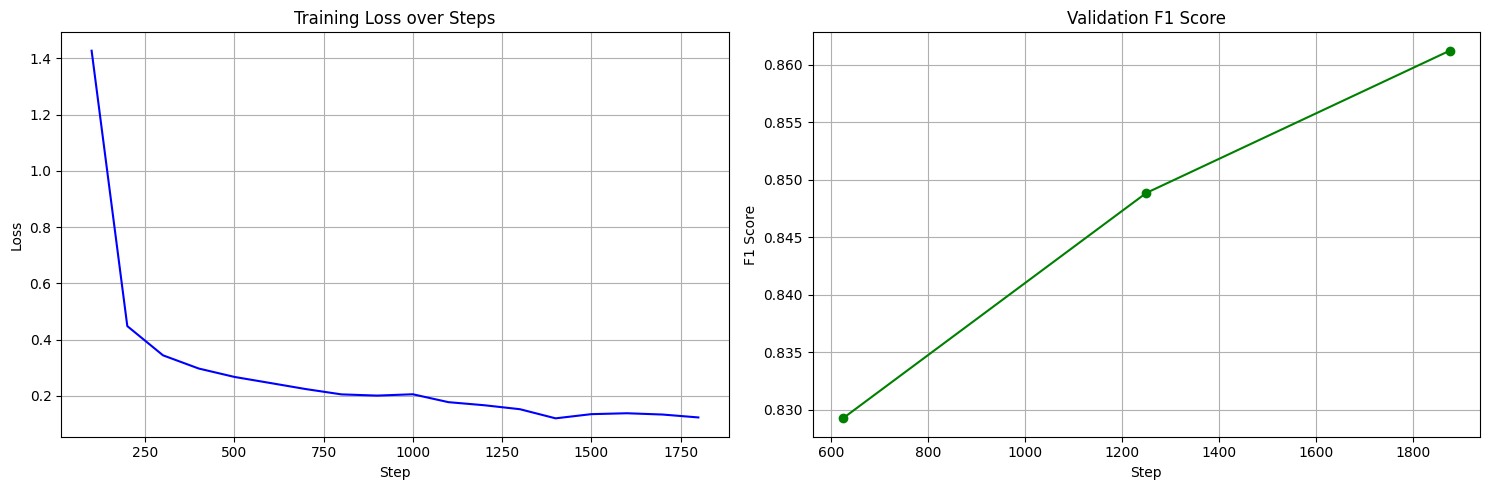

In [25]:
import json
import os
import matplotlib.pyplot as plt

def plot_training_metrics(state_file):
    # Load the trainer_state.json which contains the history
    with open(state_file, 'r') as f:
        state = json.load(f)
    
    history = state['log_history']
    
    # Extract values for plotting
    train_loss = [x['loss'] for x in history if 'loss' in x]
    train_steps = [x['step'] for x in history if 'loss' in x]
    
    eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]
    eval_steps = [x['step'] for x in history if 'eval_f1' in x]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Training Loss
    if train_loss:
        axes[0].plot(train_steps, train_loss, label='Training Loss', color='blue')
        axes[0].set_title('Training Loss over Steps')
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True)
    
    # Plot Validation F1
    if eval_f1:
        axes[1].plot(eval_steps, eval_f1, label='Eval F1', color='green', marker='o')
        axes[1].set_title('Validation F1 Score')
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('F1 Score')
        axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, "training_plots.png"))
    plt.show()

# Point this to the trainer_state.json in your output directory
plot_training_metrics('/kaggle/working/models/teacher/checkpoint-1875/trainer_state.json')

In [26]:
# Cell 19: Complete W&B run
wandb.finish()
print("\nTraining completed successfully!")

de/f1,▁
de/precision,▁
de/recall,▁
en/f1,▁
en/precision,▁
en/recall,▁
eval/accuracy,▂▄▅▅▄▁█▃
eval/f1,▁▄▆▆▅▂▅█
eval/loss,▇▅▅▅▅█▁▆
eval/precision,▁▄▆▆▅▂▄█
+16,...



Training completed successfully!
